Compiling model...
Building feed-forward neural network...
'build' took 0.028439 s

'compile' took 0.185985 s



/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2024-04-09 13:25:10.506210: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [8.90e-02, 1.14e-01, 6.95e-02, 6.40e+01, 4.90e+01, 7.29e+02, 3.29e+01, 4.06e+01, 2.62e+02]    [8.90e-02, 1.14e-01, 6.95e-02, 6.40e+01, 4.90e+01, 7.29e+02, 3.29e+01, 4.06e+01, 2.62e+02]    []  
1000      [5.70e+00, 2.75e+00, 3.15e+00, 3.07e+01, 9.07e-06, 1.89e+00, 3.30e+01, 7.72e+00, 9.77e+00]    [5.70e+00, 2.75e+00, 3.15e+00, 3.07e+01, 9.07e-06, 1.89e+00, 3.30e+01, 7.72e+00, 9.77e+00]    []  
2000      [9.23e+00, 1.96e+00, 1.30e+00, 1.81e+01, 3.32e-01, 1.63e+00, 3.30e+01, 1.42e+01, 4.96e+00]    [9.23e+00, 1.96e+00, 1.30e+00, 1.81e+01, 3.32e-01, 1.63e+00, 3.30e+01, 1.42e+01, 4.96e+00]    []  
3000      [8.95e+00, 1.92e+00, 9.69e-01, 1.45e+01, 3.75e-01, 1.51e+00, 3.29e+01, 1.73e+01, 3.32e+00]    [8.95e+00, 1.92e+00, 9.69e-01, 1.45e+01, 3.75e-01, 1.51e+0

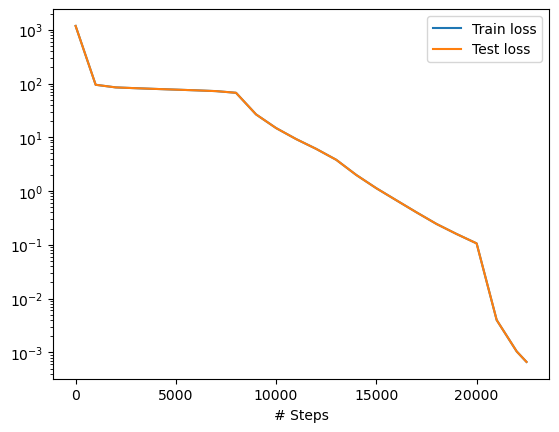

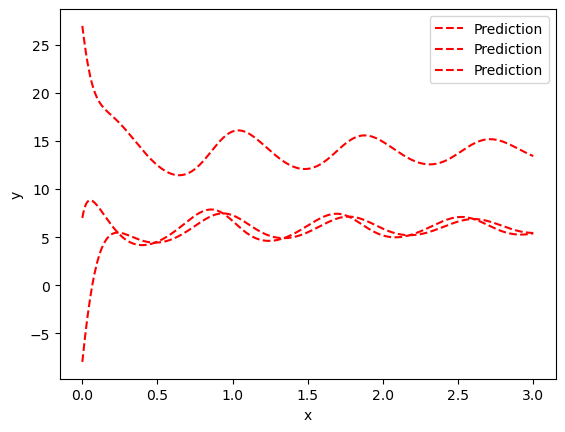

In [2]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np


def gen_traindata():
    data = np.load("Lorenz.npz")
    return data["t"], data["y"]


C1 = dde.Variable(1.0)
C2 = dde.Variable(1.0)
C3 = dde.Variable(1.0)

# Most backends
def Lorenz_system(x, y):
    """Lorenz system.
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (15 - y3) - y2
    dy3/dx = y1 * y2 - 8/3 * y3
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3,
    ]


def boundary(_, on_initial):
    return on_initial


geom = dde.geometry.TimeDomain(0, 3)

# Initial conditions
ic1 = dde.icbc.IC(geom, lambda X: -8, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda X: 7, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda X: 27, boundary, component=2)

# Get the train data
observe_t, ob_y = gen_traindata()
observe_y0 = dde.icbc.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.icbc.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.icbc.PointSetBC(observe_t, ob_y[:, 2:3], component=2)

data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=400,
    num_boundary=2,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [C1, C2, C3]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# train adam
model.compile(
    "adam", lr=0.001, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# train lbfgs
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
